In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# import the data
url  = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
df = pd.read_csv(url,sep=',',header=None)
df.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','DISEASE']


# data contain some ?'s; replace with NaN and drop those rows
df = df.replace('?',np.nan).dropna()

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,DISEASE
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [3]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,DISEASE
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.946128
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,1.234551
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


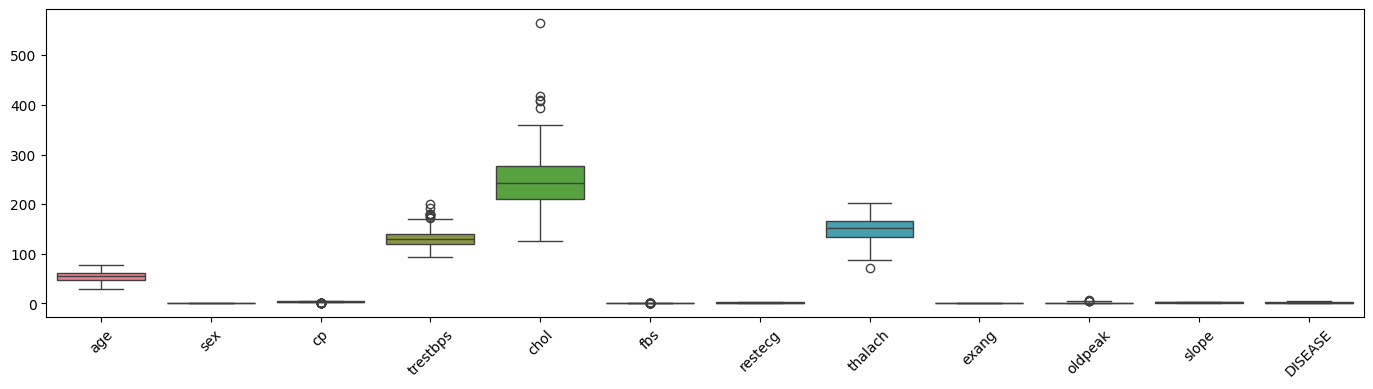

In [4]:
# check the distributions
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=df)
ax.tick_params(axis='x',rotation=45)
plt.show()

In [5]:
# Remove the outlier where chol > 500
row_to_drop = df[df['chol']>500].index
df = df.drop(row_to_drop, axis=0)

In [6]:
df['DISEASE'].value_counts(normalize=True)

,proportion
DISEASE,
0,0.537162
1,0.182432
2,0.118243
3,0.118243
4,0.043919


In [7]:
df['DISEASE'] = np.where(df['DISEASE']>0,1,0)

In [8]:
# Drop the target column
target = df['DISEASE']
df = df.drop('DISEASE',axis=1)
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [9]:
# split the data into train and test data

data_train, data_test, labels_train, labels_test = train_test_split(df, target, test_size=0.2, random_state=42)

labels_train = labels_train.values[:,None] # Convert to numpy array before reshaping
labels_test = labels_test.values[:,None] # Convert to numpy array before reshaping

In [10]:
labels_train.shape, labels_test.shape

((236, 1), (60, 1))

In [11]:
# Standard scale the dataframe
cols_to_scale = data_train.columns
cols_to_scale = cols_to_scale.drop(['sex','fbs','exang'])

ct = ColumnTransformer([('scale',StandardScaler(),cols_to_scale)],remainder='passthrough')


data_train_std = ct.fit_transform(data_train)
data_test_std = ct.transform(data_test)

features = ct.get_feature_names_out()


# Convert to pandas DataFrames with correct column names
data_train_std = pd.DataFrame(data_train_std, columns=features)
data_test_std = pd.DataFrame(data_test_std, columns=features)

data_train_std = torch.tensor(data_train_std.values, dtype=torch.float32)
data_test_std = torch.tensor(data_test_std.values, dtype=torch.float32)

In [12]:
# Convert the train and test laoders into Pytorch DataLoader

train_data = TensorDataset(data_train_std, torch.tensor(labels_train, dtype=torch.float32))
test_data = TensorDataset(data_test_std, torch.tensor(labels_test, dtype=torch.float32))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0], shuffle=False)

# Create the model

In [13]:
class FFNmodel(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(13,32) # Reduced neurons
    # self.dropout1 = nn.Dropout(0.2) # Added dropout layer
    self.fc2 = nn.Linear(32,64) # Reduced neurons
    self.fc3 = nn.Linear(64,10)
    self.fc4 = nn.Linear(10,1)

  def forward(self,x):
    x = F.relu(self.fc1(x))
    # x = self.dropout1(x) # Applied dropout
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)

    return x

In [26]:
def HeartDiseaseModel(learning_rate=0.0001):
  model = FFNmodel()

  # Loss Function
  loss_fn = nn.BCEWithLogitsLoss()

  # Optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Reduced learning rate

  return model, loss_fn, optimizer

# Train the model

In [27]:
def trainModel(nEpochs,learning_rate):
  model,loss_fn,optimizer = HeartDiseaseModel(learning_rate)

  losses = np.zeros((nEpochs,2))
  accuracies = np.zeros((nEpochs,2))

  for epochi in range(nEpochs):
    batchlosses = []

    # Training Loop
    model.train()

    for X_train,y_train in train_loader:
      y_pred = model(X_train)
      loss_train = loss_fn(y_pred,y_train)

      # Initialize the gradient
      optimizer.zero_grad()

      # Compute the gradient
      loss_train.backward()

      # Update the weights
      optimizer.step()

      batchlosses.append(loss_train.item())

      # Calculate the batch accuracy
      pred_train = (torch.sigmoid(y_pred) > 0.5).float()
      matches_train = (pred_train == y_train).float()
      accuracies[epochi,0] = 100 * torch.mean(matches_train)

      # End of batch loop

    losses[epochi,0] = np.mean(batchlosses)

    # testing Loop
    model.eval()

    X_test, y_test = next(iter(test_loader))
    with torch.no_grad():
      yHat = model(X_test)

    # Calcuate test loss
    loss_test = loss_fn(yHat,y_test)
    losses[epochi,1] = loss_test.item()

    # Calcuate test accuracy
    pred_test = torch.sigmoid(yHat) > 0.5
    matches_test = (pred_test==y_test).float()
    accuracies[epochi,1] = 100 * torch.mean(matches_test)

  # return model, losses, accuracies
  return model, losses, accuracies

# Run the model

In [64]:
model, losses, accuracies = trainModel(nEpochs=20,learning_rate=0.001)

# Visualize the model

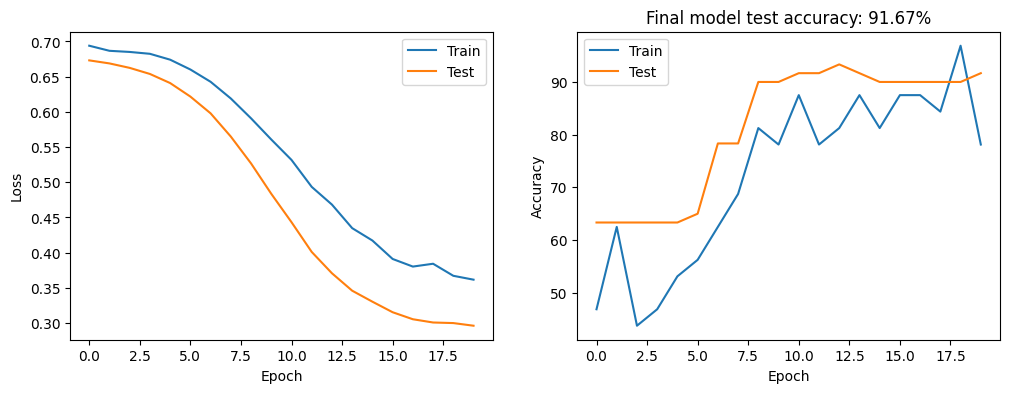

In [65]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

for i in range(2):
  ax[0].plot(losses[:,i],label=str(['Train','Test'][i])) # Cast label to string
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()


for i in range(2):
  ax[1].plot(accuracies[:,i],label=str(['Train','Test'][i])) # Cast label to string
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title(f'Final model test accuracy: {accuracies[-1,1]:.2f}%')
ax[1].legend()

plt.show();